<a href="https://colab.research.google.com/github/Bruj22/test2/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rujnichatienngam","key":"392caa935141deed611588fef1c5234d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 91% 55.0M/60.3M [00:00<00:00, 76.2MB/s]
100% 60.3M/60.3M [00:00<00:00, 71.9MB/s]


In [2]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [4]:
#Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       surprise  fear  neutral  happy  angry  disgust   sad
train      3171  4097     4965   7215   3995      436  4830
      surprise  fear  neutral  happy  angry  disgust   sad
test       831  1024     1233   1774    958      111  1247


<Axes: >

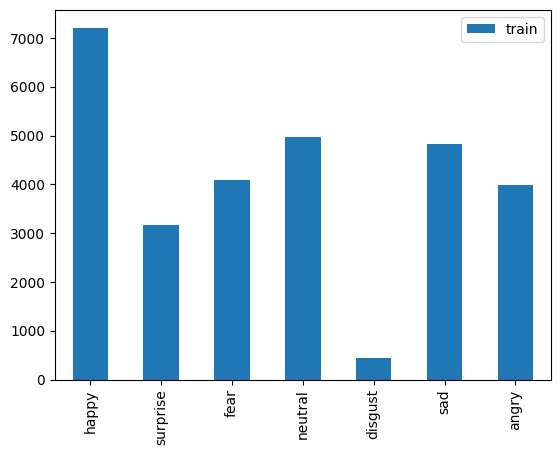

In [ ]:
train_count.transpose().plot(kind='bar')

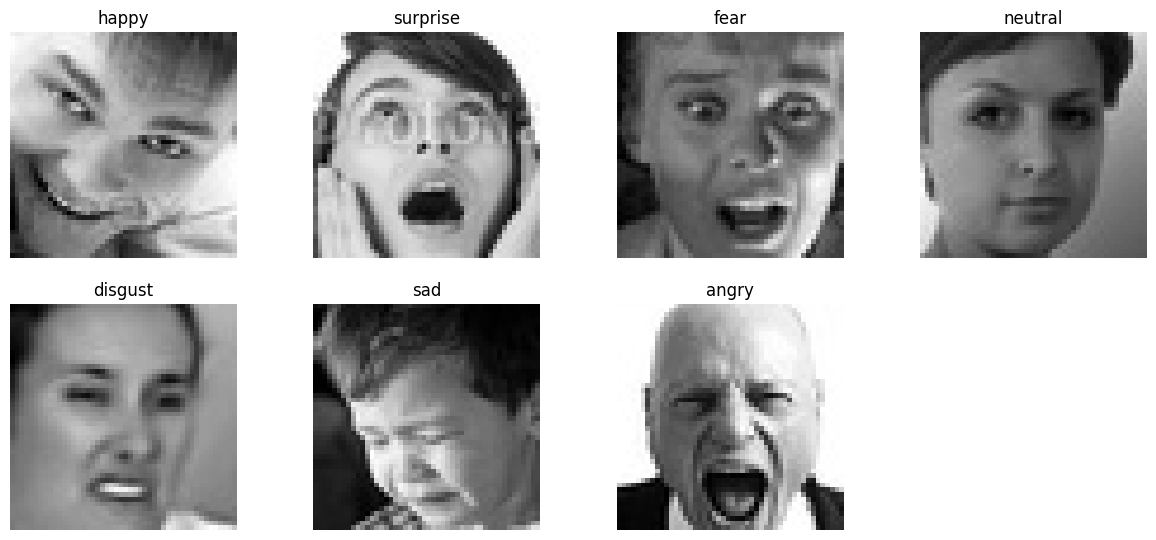

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [5]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

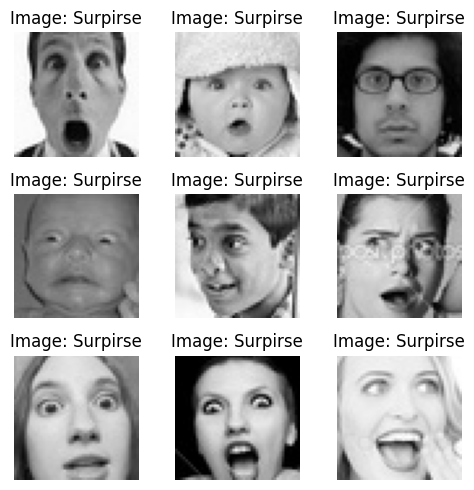

In [6]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

In [7]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [8]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


In [9]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 4
epochs = 100
num_classes = 7  # Update this based on the number of your classes

In [10]:
# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [11]:
# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5742/5742 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - accuracy: 0.2431 - loss: 5.3802 - val_accuracy: 0.2513 - val_loss: 1.8123
Epoch 2/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.2465 - loss: 1.8175 - val_accuracy: 0.2513 - val_loss: 1.8103
Epoch 3/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.2521 - loss: 1.8142 - val_accuracy: 0.2513 - val_loss: 1.8101
Epoch 4/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.2418 - loss: 1.8156 - val_accuracy: 0.2513 - val_loss: 1.8134
Epoch 5/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.2534 - loss: 1.8146 - val_accuracy: 0.2513 - val_loss: 1.8109
Epoch 6/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.2525 - loss: 1.8102 - val_accuracy: 0.2513 - val_loss: 1.8126
Epoch 7/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.2531 - loss: 1.8109 - val_accuracy: 0.2513 - val_loss: 1.8159
Epoch 8/100
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.2558 - loss: 1.809

In [14]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model2 = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.3))

model2.add(Conv2D(256, (3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.4))

model2.add(Dense(7, activation='softmax'))

# Compile
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2)


In [ ]:
history2 = model2.fit(
    train_generator,
    epochs=120,
    batch_size=4,
    validation_data=validation_generator,
    callbacks=[early_stop])

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5742/5742 ━━━━━━━━━━━━━━━━━━━━ 787s 136ms/step - accuracy: 0.2114 - loss: 2.0286 - val_accuracy: 0.2561 - val_loss: 1.8122
Epoch 2/120
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 800s 136ms/step - accuracy: 0.2288 - loss: 1.8404 - val_accuracy: 0.2517 - val_loss: 1.7974
Epoch 3/120
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 778s 132ms/step - accuracy: 0.2374 - loss: 1.8228 - val_accuracy: 0.2534 - val_loss: 1.7989
Epoch 4/120
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 776s 135ms/step - accuracy: 0.2411 - loss: 1.8084 - val_accuracy: 0.2592 - val_loss: 1.7902
Epoch 5/120
5742/5742 ━━━━━━━━━━━━━━━━━━━━ 776s 135ms/step - accuracy: 0.2618 - loss: 1.7869 - val_accuracy: 0.2735 - val_loss: 1.7657
Epoch 6/120
